# Building a deep convolutional neural network to detect vocalisation events of birds

In [1]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install -U librosa
# !pip freeze | grep librosa
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.2 MB/s eta 0:00:00


## Step 0: Download data and code

This requires Google account authentication.

In [2]:
colab = True

In [3]:
# This snippet of code can take up to 5 minutes or so.
# Plase allow this to complete.
if colab:
    !pip install SoundFile
    from google.colab import drive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import zipfile

    # Google Authentication
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Download code files
    downloaded = drive.CreateFile({'id':"1js1fz4Bu98NIds4cErL7NdT1efxavixp"})
    downloaded.GetContentFile('Code.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Code.zip', 'r') as zip_file:
        zip_file.extractall()

    # Download data files
    downloaded = drive.CreateFile({'id':"1ZtnBNlAttwSqiYF4XPfNLE6YX5H8HDAa"})
    downloaded.GetContentFile('Data.zip')

    # Extract files to temporary location in Google Drive
    with zipfile.ZipFile('Data.zip', 'r') as zip_file:
        zip_file.extractall()

In [4]:
from Preprocessing import *
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

## Step 1: Pre-process the data

In [5]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser
# -----------------------------
positive_class = ['1'] # which labels should be bundled together for the positive  class
negative_class = ['0'] # which labels should be bundled together for the negative  class


# Data hyper-parameters
# -----------------------------
lowpass_cutoff = 2000 # Cutt off for low pass filter
downsample_rate = 22050 # Frequency to downsample to
nyquist_rate = 11025 # Nyquist rate (half of sampling rate)
segment_duration = 4 # how long should a segment be


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 4000 # Spectrogram, minimum frequency for call
f_max = 9000 # Spectrogram, maximum frequency for call

# Mel frequency cepstral coefficients hypperparameters
n_mfccs = 19

# Don't change these
# -----------------------------
species_folder = '.' # Should contain /Audio and /Annotations
file_type = 'svl' # Sonic Visualizer annotation file extension
audio_extension = '.wav' # Audio file extension
audio_files_directory = "Audio/" # Diredtory of the audio files.
test_files_path = "DataFiles/TestingFiles.txt" # Path to the text file containing names of all the test files

In [6]:
# This takes about 1 minute
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                positive_class, negative_class,n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False)

Processing: 19_19_fermat_15
Found file
Filtering...
Downsampling...
19_19_fermat_15
Reading annotations...
Processing: 23_2-2-2024=20_53_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_53_19
Reading annotations...
Processing: 6_2-2-2024=14_46_17
Found file
Filtering...
Downsampling...
6_2-2-2024=14_46_17
Reading annotations...
Processing: 9_2-2-2024=21_1_26
Found file
Filtering...
Downsampling...
9_2-2-2024=21_1_26
Reading annotations...
Processing: 6_2-2-2024=14_43_57
Found file
Filtering...
Downsampling...
6_2-2-2024=14_43_57
Reading annotations...
Processing: 23_2-2-2024=20_39_55
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_55
Reading annotations...
Processing: 15_audio_34
Found file
Filtering...
Downsampling...
15_audio_34
Reading annotations...
Processing: 15_audio_79
Found file
Filtering...
Downsampling...
15_audio_79
Reading annotations...
Processing: 8_emmanuel_5
Found file
Filtering...
Downsampling...
8_emmanuel_5
Reading annotations...
Processing: 23_2-

## Data shapes

In [7]:
print(X.shape)
print(Y.shape)


(5782, 88200)
(5782,)


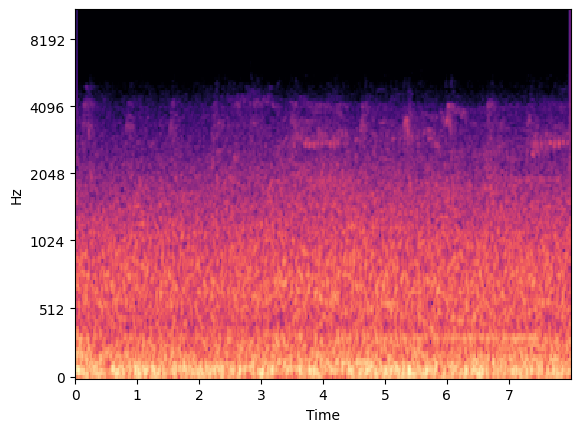

In [8]:
#stft = librosa.stft(X[1], n_fft=1024, hop_length=256)
  # Convert to Mel scale
spectrogram = librosa.feature.melspectrogram(y = X[1000], n_fft=n_fft, hop_length=256)

spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')

The following function constructs a mel-spectrogram from an audio sample using librosa.

In [9]:
def audio_to_spectrogram(audio):
    """
    Convert single audio to a mel-spectrogram.

    Parameters
    ----------
    audio : ndarray
        A a numpy array of the audio to be converted.

    Returns
    -------
    ndarray :
        A log transformed mel-spectrogram.
    """
    spectrogram = librosa.feature.melspectrogram(y = audio, n_fft=n_fft, hop_length=256, n_mels=128, fmax = f_max, fmin = f_min)
    spectrogram = (spectrogram - spectrogram.mean()) / spectrogram.std()
    log_spectrogram = librosa.power_to_db(spectrogram)
    return log_spectrogram

This function computes the Mel Frequency Cepstral Coefficients from the specified mel-spectrogram. The computed coefficients encodes in a compact form, the features of the signal, thus effectively reducing the dimensionality of the signal.

In [10]:
def compute_mfccs(mel_spectrogram, n_mfccs):
  """
  Compute the mel frequency cepstral coefficients.

  Parameters
  ----------
  mel_spectrogram : ndarray.
      The mel spectrogram whose MFCCs is to be computed.
  n_coeffs : int
      The number of cepstral coefficients to compute.

  Returns
  -------
  ndarray :
      a two dimensional numpy array MFCCs.
  """
  mfccs = librosa.feature.mfcc(S=mel_spectrogram, n_mfcc=n_mfccs)
  return mfccs

This function plots the mel-spectrogram along with the MFCCs, for the purpose of comparison.

In [11]:
def juxtapose_mel_mfccs(mel_spectrogram, mfccs):
  """
  Generate a mel spectrogram plot and an MFCCs plot.

  Parameters
  ----------
  mel_spectrogram : ndarray.
      The mel spectrogram to plot.
  mfccs : ndarray.
      The mel frequency cepstral coefficients to plot.
  """
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 1, 1)
  librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
  plt.title('Mel Spectrogram')

  plt.subplot(2, 1, 2)
  librosa.display.specshow(mfccs, x_axis='time')
  plt.colorbar()
  plt.title('MFCCs')

  plt.tight_layout()
  plt.show()

This function visualizes or makes the number of plots you want to make of the mel-specrogram and MFCCs.

In [12]:
def visualize_mel_mfccs(n_mfccs, n_plots, presence = True):
  """
  Visualize a number of plots.

  This function randomly chooses some mel spectrograms together with their
  corresponding MFCCs, and plots them by calling the juxtapose_mel_mfccs
  function.

  Parameters
  ----------
  n_mfccs : int.
      Number of coefficients to compute (MFCCs).
  n_plots : int.
      The number of plots to make.
  presence : boolean
      Indicates if the spectrogram is a bird vocalization or
      non-vocalization.
  """
  # Cast the boolean into an int (0 or 1), and then cast into a string (the label).
  presence_value = str(int(presence))
  for i in range(n_plots):
    # Get a random index of the specified label (vocalization or non-vocalization).
    vocalization_index = np.random.choice(np.where(Y == presence_value)[0])
    mel = audio_to_spectrogram(X[vocalization_index])
    mfccs = compute_mfccs(mel, n_mfccs)
    print(Y[vocalization_index])
    juxtapose_mel_mfccs(mel, mfccs)

## Randomly visualize two vocalization events
Visualize 2 mel spectrogram and MFCCs for bird vocalization events. The top one is the mel-spectrogram, and the bottom is a plot of the corresponding MFCCs.

1


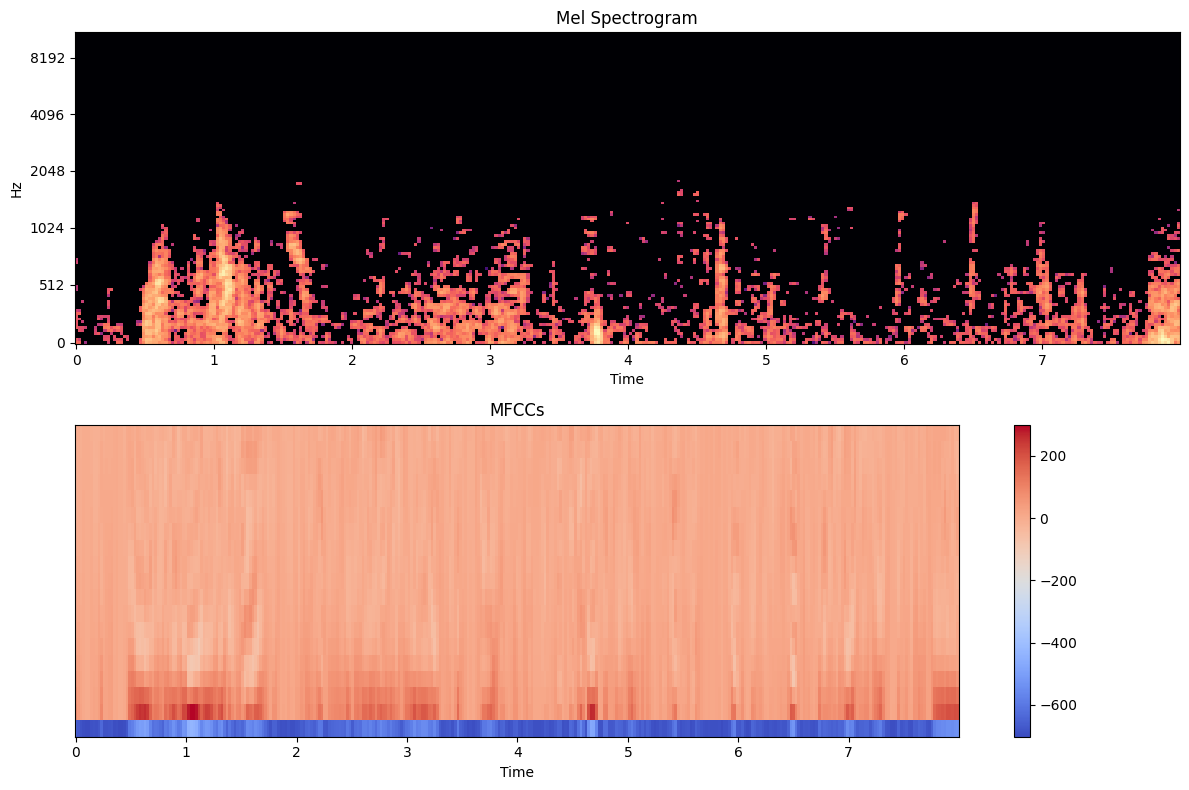

1


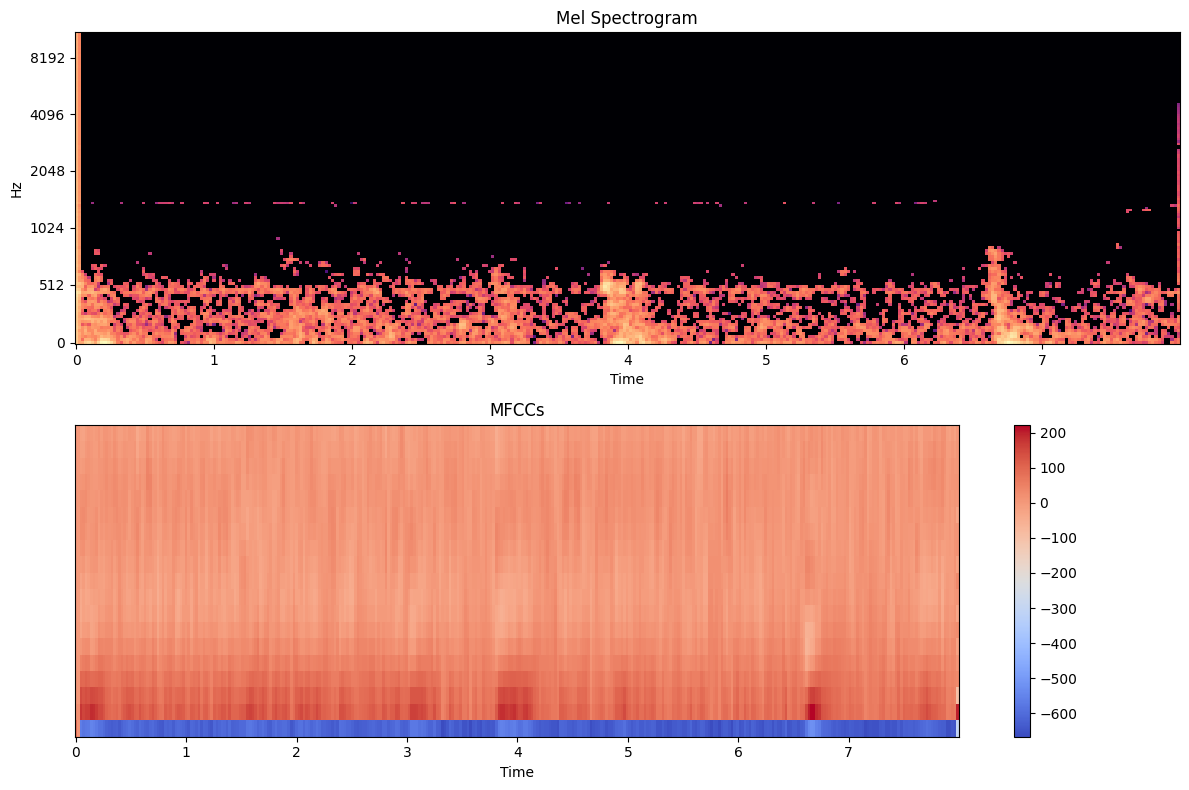

In [13]:
visualize_mel_mfccs(n_mfccs = n_mfccs, n_plots = 2)

## Randomly visualize two non-vocalization events
Visualize 2 mel spectrogram and MFCCs for non-vocalization events. The top one is the mel-spectrogram, and the bottom is a plot of the corresponding MFCCs.

0


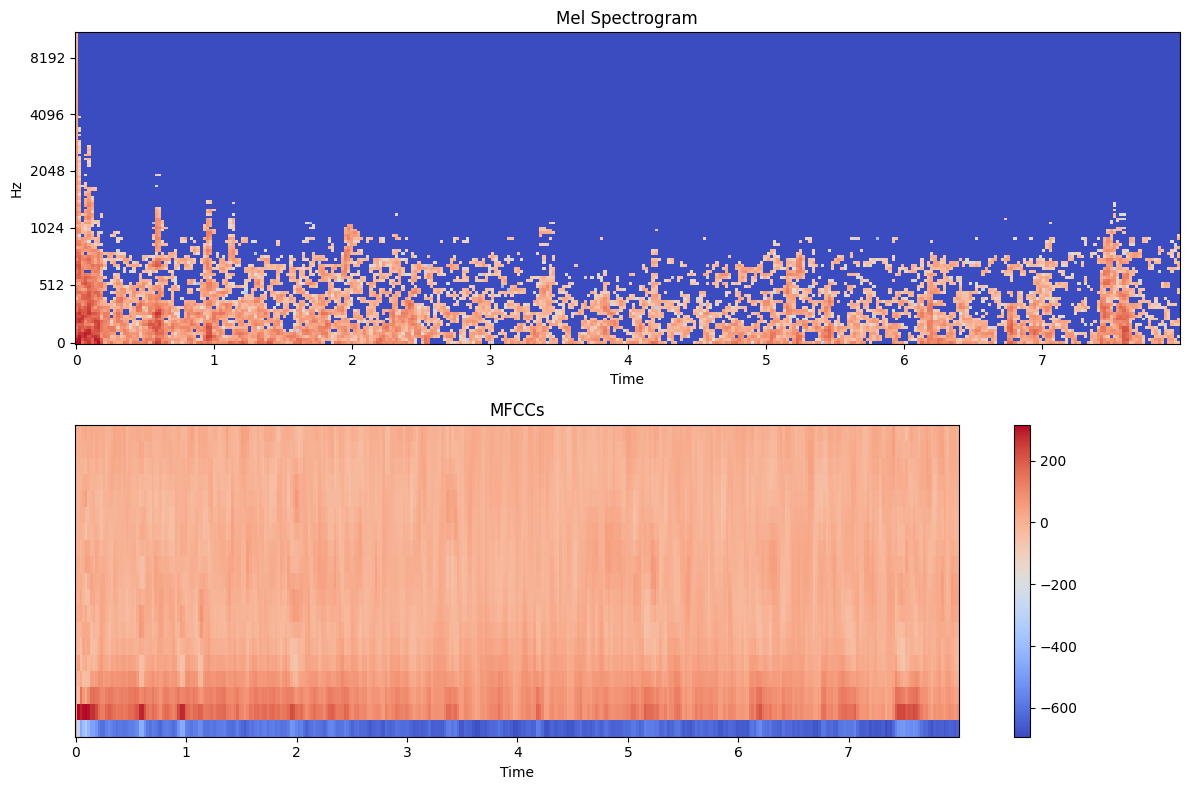

0


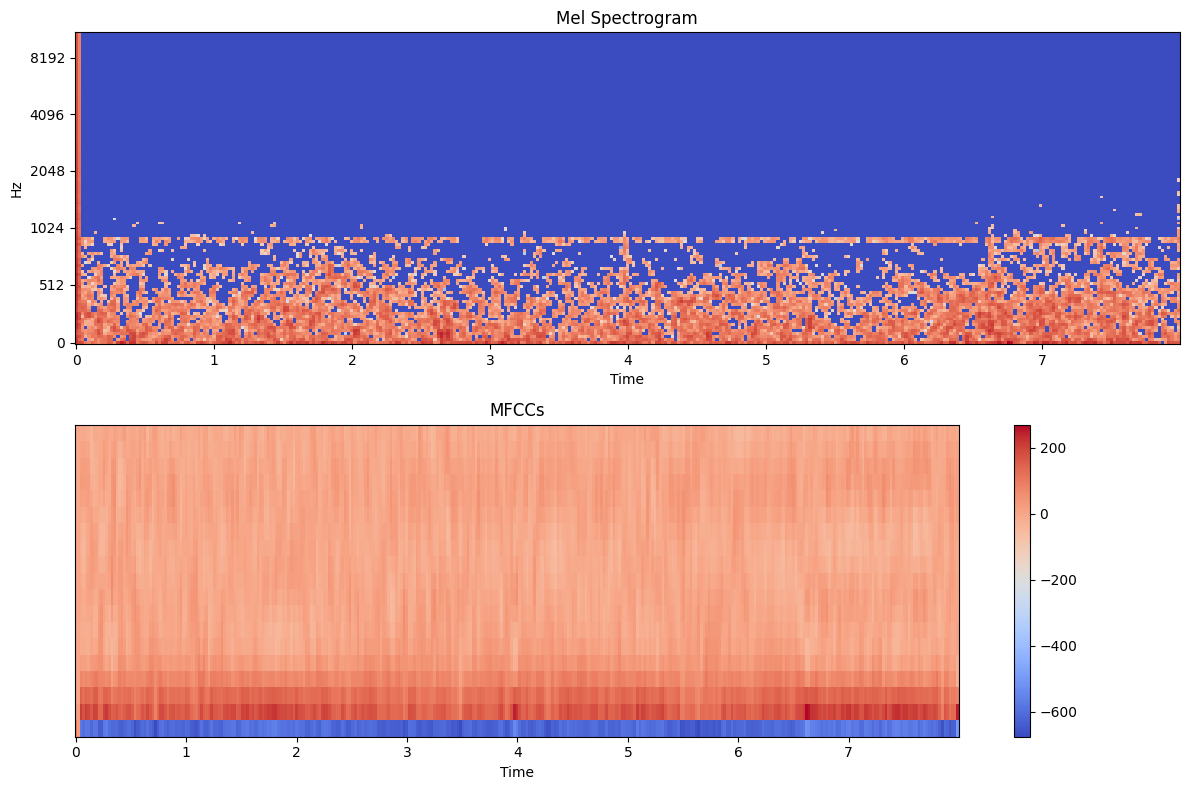

In [14]:
visualize_mel_mfccs(n_mfccs = n_mfccs, n_plots = 2, presence = False)

Here is a function that will convert all of the audio segments into MFCCs.

In [15]:
#uni, counts = np.unique(Y, return_counts = True)
#print(uni)
#print(counts)
#print(np.unique(Y, return_counts = True)[1])

In [16]:
def convert_all_to_mfccs(segments):
  mfccs = []
  for segment in segments:
    spectrogram = audio_to_spectrogram(segment)
    mfccs.append(compute_mfccs(spectrogram, n_mfccs))
  return np.array(mfccs)

Create all the spectrograms

In [17]:
X_S = convert_all_to_mfccs(X)

Free some RAM so that we can another dataset.

In [18]:
# We don't need this variable anymore.
del X

The initial dataset (X, Y) was loaded from only ".wav" audio files since `Preprocessing.py` script does not look for both **".wav"** and **".WAV"** extensions at the same time. However, the audio folder contains audio files with both ".wav" and ".WAV" extensions. One way to get around this problem without modifying the script, is to set `pre_pro.audio_extension` to ".WAV", so that we can also load audio files with that extension and create a dataset using the `pre_pro.create_dataset` function.

In [19]:
# Set the audio_extension to .WAV, so Preprocessing.py can find
# and load audio files with .WAV extensions.
pre_pro.audio_extension = ".WAV"

# Create a new dataset from the audio files.
new_X, new_Y = pre_pro.create_dataset(False)


Processing: 19_19_fermat_15
Processing: 23_2-2-2024=20_53_19
Processing: 6_2-2-2024=14_46_17
Processing: 9_2-2-2024=21_1_26
Processing: 6_2-2-2024=14_43_57
Processing: 23_2-2-2024=20_39_55
Processing: 15_audio_34
Processing: 15_audio_79
Processing: 8_emmanuel_5
Processing: 23_2-2-2024=20_38_50
Processing: 2_2_someaudiofile_1
Processing: 5_2-2-2024=15_20_0
Processing: 12_audio_16
Processing: 22_3-2-2024=7_8_50
Processing: 19_19_fermat_5
Processing: 23_2-2-2024=20_45_9
Processing: 23_2-2-2024=20_42_15
Processing: 18_3-2-2024=6_50_29
Processing: 20_r17_dariose
Processing: 7_7_2-2-2024=15_20_15
Processing: 28_2-2-2024=14_43_47
Processing: 12_audio_15
Processing: 14_2-2-2024=19_38_59
Processing: 19_19_fermat_7
Processing: 7_7_2-2-2024=15_21_31
Processing: 21_20240203_063015
Found file
Filtering...
Downsampling...
21_20240203_063015
Reading annotations...
Processing: 2_2_someaudiofile_20
Processing: 7_7_2-2-2024=15_21_25
Processing: 5_2-2-2024=15_18_8
Processing: 25_2-2-2024=19_41_47
Process

Construct a new array of MFCCs from the new audio samples.

In [20]:
X_S_new = convert_all_to_mfccs(new_X)

Free up some RAM.

In [21]:
# We don't need this variabel anymore.
del new_X

We need to combine the first dataset with the second dataset to get the full dataset for all the audio files in the Audio folder.

In [22]:
# Concatenate the MFCCs from the first dataset with the MFCCs from the
# second dataset.
X_S = np.concatenate((X_S, X_S_new), axis = 0)

# Concatenate the labels from the first dataset with the labels from the
# second dataset.
Y = np.concatenate((Y, new_Y), axis = 0)

Print the shape of the entire dataset.

In [23]:
print(X_S.shape)
print(Y.shape)

(9092, 19, 345)
(9092,)


## Distribution of labels

In [24]:
unique, counts = np.unique(Y, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 1400, '1': 7692}


This function receives one spectrogram (2D matrix).

It also receives the true target value for that spectrogram

In [25]:
def augment_one_spectrogram(spectrogram, true_target):
    """"
    Augment a single spectrogram.

    This function masks random rectangular regions
    on the spectrogram.

    Parameters
    ----------
    spectrogram :
        A 2D ndarray.
    true_target :
        Actual label for the spectrogram.

    Returns
    -------
    ndarray
        A modified mel-spectrogram with a mask.
    """
    # Define width of the rectangular area to mask
    width = 4

    # Get a random starting point/column for the rectangle
    start_column = np.random.randint(15, 300)
    new_spectrogram = np.copy(spectrogram)

    # Set the columns from freqs to freqs + width to 0
    new_spectrogram[start_column: start_column + width:, ] = 0

    return new_spectrogram, true_target

This function will randomly select one spectrogram which contains a bird vocalization.

In [26]:
def randomly_select_presence(all_spectrograms, targets):

  # Find all the indices where there is a vocalization.
  presence_indices = np.where(targets =='1')[0]

  # Randomly select index
  random_index = random.randint(0,len(presence_indices)-1)

  return all_spectrograms[presence_indices[random_index]]

This function will randomly select one spectrogram which does not contain a bird vocalization.

In [27]:
def randomly_select_absence(all_spectrograms, targets):

  # Find all the indices where there is no vocalization.
  absence_indices = np.where(targets =='0')[0]

  # Randomly select index
  random_index = random.randint(0,len(absence_indices)-1)

  return all_spectrograms[absence_indices[random_index]]

This function will generate one new spectrogram with a bird vocalization in it.

In [28]:
def generate_new_presence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    presence_spectrogram = randomly_select_presence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(presence_spectrogram,
                                                                      '1')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

This function will generate one new spectrogram without a bird vocalization.

In [29]:
def generate_new_absence_spectrograms(all_spectrograms, all_targets, quantity):

  new_spectrograms = []
  new_targets = []

  for i in range (0, quantity):
    absence_spectrogram = randomly_select_absence(all_spectrograms, all_targets)
    augmented_spectrogram, augmented_target = augment_one_spectrogram(absence_spectrogram,
                                                                      '0')

    new_spectrograms.append(augmented_spectrogram)
    new_targets.append(augmented_target)

  return np.asarray(new_spectrograms), np.asarray(new_targets)

* Now generate 1000 augmented bird vocalization.

In [30]:
new_presence, new_targets = generate_new_presence_spectrograms(X_S, Y, 1000)

Check the shapes of the newly created data

In [31]:
print(new_presence.shape)
print(new_targets.shape)

(1000, 19, 345)
(1000,)


## Randomly select two of the newly created MFCCs, and visualize them.

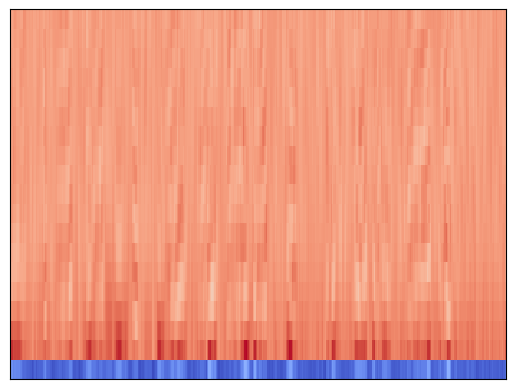

In [32]:
librosa.display.specshow(new_presence[np.random.randint(0, 999)])

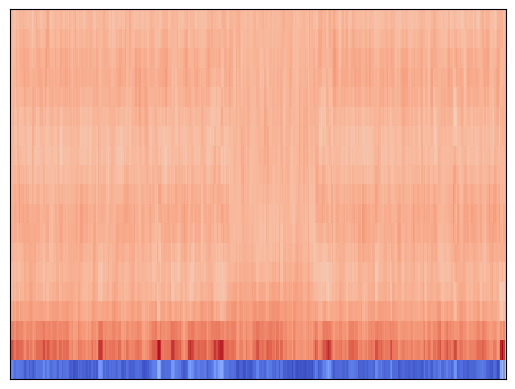

In [33]:
librosa.display.specshow(new_presence[np.random.randint(0, 999)])

## Combine all existing MFCCs which contain bird vocalizations all the newly created ones.

In [34]:
X_positive = np.concatenate([X_S[np.where(Y =='1')], new_presence])
X_positive = np.asarray(X_positive)
print(X_positive.shape)

Y_positive = np.concatenate([Y[np.where(Y =='1')], new_targets])
Y_positive = np.asarray(Y_positive)
print(Y_positive.shape)

# Free some RAM here.
del new_presence

(8692, 19, 345)
(8692,)


* Now generate 7000 augmented absence MFCCs to make the dataset balanced, as there are far more vocalization events than non-vocalization events.

In [35]:
new_absence, new_targets = generate_new_absence_spectrograms(X_S, Y, 7000)

Check the shapes of the newly created data

In [34]:
print(new_absence.shape)
print(new_targets.shape)

(7000, 19, 345)
(7000,)


## Randomly visualize two non-vocalization samples

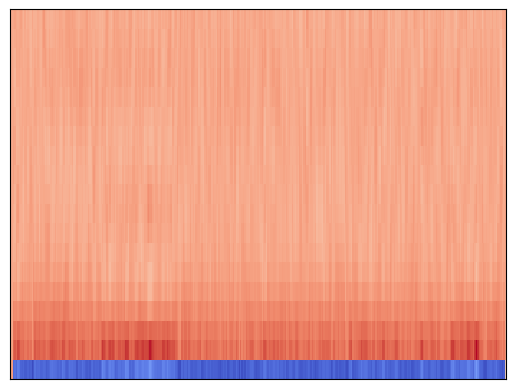

In [36]:
librosa.display.specshow(new_absence[np.random.randint(0, 6999)])

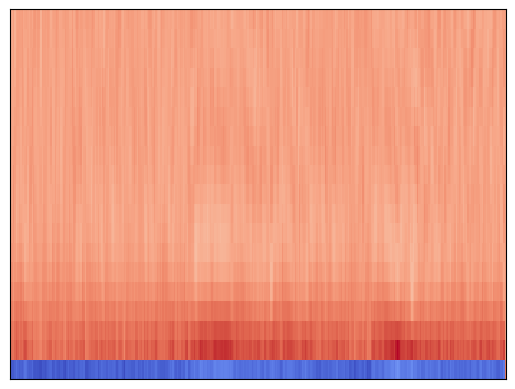

In [37]:
librosa.display.specshow(new_absence[np.random.randint(0, 6999)])

## Combine all existing MFCCs which do not contain bird vocalizations all the newly created ones.

In [38]:
X_negatives = np.concatenate([X_S[np.where(Y =='0')], new_absence])
X_negatives = np.asarray(X_negatives)
print(X_negatives.shape)

Y_negatives = np.concatenate([Y[np.where(Y =='0')], new_targets])
Y_negatives = np.asarray(Y_negatives)
print(Y_negatives.shape)

(8400, 19, 345)
(8400,)


Free some RAM.

In [39]:
# We don't need this variable anymore.
del new_absence

Combine all the positive features and negative features. Do the same for the targets

In [40]:
X_dataset = np.concatenate([X_positive, X_negatives])
Y_dataset = np.concatenate([Y_positive, Y_negatives])

Check the shapes of the completed dataset.

In [41]:
print(X_dataset.shape)
print(Y_dataset.shape)

(17092, 19, 345)
(17092,)


Reshape so that the data is in a format that is ready for Tensorflow.

In [42]:
X_dataset = np.expand_dims(X_dataset, axis=-1)

Check the shape again

In [43]:
print(X_dataset.shape)
print(Y_dataset.shape)

(17092, 19, 345, 1)
(17092,)


Some pre-processing to convert the categorical targets into one-hot encoded ones

In [44]:
from tensorflow.keras.utils import to_categorical
call_order = ['0','1']

# Converting categorical string labels ('1' and '0) to 0s and 1s
for index, call_type in enumerate(call_order):
    Y_dataset = np.where(Y_dataset == call_type, index, Y_dataset)

Y_dataset = to_categorical(Y_dataset,
                             num_classes = 2)

Check shapes again

In [45]:
print(X_dataset.shape)
print(Y_dataset.shape)

(17092, 19, 345, 1)
(17092, 2)


Free some RAM

In [46]:
# We won't need this variable anymore.
del X_S

##Model architecture
Three Convolutional layers, two MaxPooling layers, one AveragePooing layer and one fully connected layer, with output shape of (2,) for the two classes.

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_dataset, Y_dataset, test_size=0.2, random_state=42)

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [49]:
m_input_shape = X_dataset.shape[1:]

In [50]:
del X_dataset, Y_dataset, X_train, X_val, y_train, y_val

In [51]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=m_input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(1, 1)))
# model.add(layers.AveragePooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(1, 1)))
# model.add(layers.AveragePooling2D(pool_size=(1, 1)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 17, 343, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 17, 343, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 17, 343, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 15, 341, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 341, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 170, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 168, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 168, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 168, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 53760)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,440,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,497,474 (13.34 MB)

 Trainable params: 3,497,026 (13.34 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [52]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [153]:
X_train.shape

(13673, 19, 345, 1)

In [53]:
# Train the model
# history = model.fit(train_dataset, validation_data=val_dataset, validation_split = 0.2, epochs=20, callbacks=[early_stopping])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.7712 - loss: 0.4951 - precision: 0.7712 - val_accuracy: 0.8617 - val_loss: 0.3514 - val_precision: 0.8617
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - accuracy: 0.9330 - loss: 0.1983 - precision: 0.9330 - val_accuracy: 0.9327 - val_loss: 0.1953 - val_precision: 0.9327
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.9836 - loss: 0.0674 - precision: 0.9836 - val_accuracy: 0.7666 - val_loss: 1.1514 - val_precision: 0.7666
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.9855 - loss: 0.0508 - precision: 0.9855 - val_accuracy: 0.7751 - val_loss: 0.6236 - val_precision: 0.7751
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.9928 - loss: 0.0267 - precision: 0.9928 - val_accuracy: 0.9547 - val_loss: 0.1659 - val_precision: 0.9547
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 579s 1s/step - accuracy: 0.9921 - loss: 0.0320 - precision: 0.9921 - val_accuracy: 0.9591 - val

Plot the loss and accuracy.

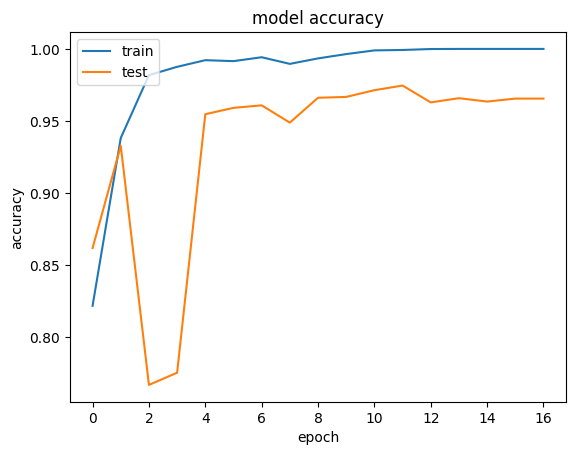

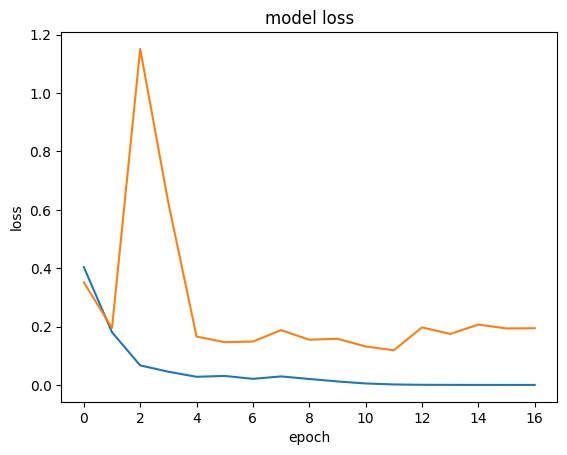

In [54]:
# Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Model Testing

Below I have provided some pre-processing code. The pre-processing of the training data used all of these functions, below, but they were hidden from you. They are actually in the Preprocessing.py file provided. You don't have to worry about anything here.

In [55]:
from scipy import signal

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def downsample_file(amplitudes, original_sr, new_sample_rate):
    return librosa.resample(y=amplitudes,
                            orig_sr=original_sr,
                            target_sr=new_sample_rate,
                            res_type='kaiser_fast'), new_sample_rate

The function below will predict on the audio data in a sliding window manner. This assumes a 4 second input window! It also assumes that the spectrograms will be of a certain shape.

In [56]:
import math
def predict_on_entire_file(audio, sample_rate, lowpass_cutoff,
                           downsample_rate, nyquist_rate):

    # Apply a low pass fitler to get rid of high frequency components
    filtered = butter_lowpass_filter(audio, lowpass_cutoff, nyquist_rate)

    # Downsample the audio
    amplitudes, sample_rate = downsample_file(filtered, sample_rate, downsample_rate)

    # Duration of file
    file_duration = len(amplitudes)/sample_rate

    # Number of segments
    segments = math.floor(file_duration) - 4

    # Store predictions in this list
    predictions = []

    # Loop over the file and work in small "segments"
    for position in range (0, segments):

        # Determine start of segment
        start_position = position

        # Determine end of segment
        # TO DO: make sure you enter the correct duration here based on the above
        end_position = start_position + 3

        # print('start position:', start_position)
        # print('end position:', end_position)

        # Extract a 4 second segment from the audio file
        audio_segment = amplitudes[start_position * downsample_rate : end_position * downsample_rate]

        # print(len(audio_segment))

        # Create the spectrogram
        S = compute_mfccs(audio_to_spectrogram(audio_segment), n_mfccs)

        # print(S.shape)

        # Input spectrogram into model
        # TO DO: make sure you enter the correct shape here
        softmax = model.predict(np.reshape(S, (1,) + S.shape), verbose = 0)

        # print ('model output:', softmax)

        # Binary output
        binary_prediction = np.argmax(softmax,-1)

        # print ('binary output:', binary_prediction[0])

        # Append result
        # result = 'absence' if np.argmax(softmax,-1)[0]== 0 else 'presence'
        if (np.argmax(softmax,-1)[0] == 1):
          predictions.append(start_position)
          #print(np.argmax(softmax,-1)[0] == 1)
        # print()

    return predictions

In [57]:
def summarize_predictions(predictions, test_file_name):
    """
    Print information about the file being predicted.

    This function prints the total number of detected vocalizations,
    and the start times where those vocalizations were detected
    for each test file.

    Parameters
    ----------
    predictions : ndarray
        Contains a list of all predicted labels.
    test_file_name : str
        name of the test file the predictions are run on.mod
    """
    print("--------------------------------------------------")
    print("Predictions on file {}".format(test_file_name))
    print("Vocalizations: ", len(predictions))
    print("Start times: ", predictions)



In [58]:
def load_test_files(path):
  """
  Load the text file.

  This function loads the TestingFiles.txt file that contains all the names
  of the files to be tested. It then splits them into an array of file names.

  Parameters
  ----------
  path : str
      The path to the TestingFiles.txt file.

  Returns
  -------
  ndarray
      An array containing all the names of the files to be tested.
  """
  test_file_names = np.genfromtxt(fname = path, delimiter = '\n', dtype = np.str_)
  return test_file_names

In [59]:
def predict_on_test_files():
  """
  Make predictions on test files.

  This function loads each of the audio files listed in TestingFiles.txt
  and makes predictions over segments of each file. It then prints
  informations such as the start times where each vocalization was detected.
  """
  test_file_names = load_test_files(test_files_path)

  for test_file_name in (test_file_names):
    lower_extension = audio_files_directory + test_file_name + audio_extension
    upper_extension = audio_files_directory + test_file_name + audio_extension.upper()
    test_file_path = None

    if(os.path.exists(lower_extension)):
      test_file_path = lower_extension

    elif(os.path.exists(upper_extension)):
      test_file_path = upper_extension

    if(test_file_path):
      audio_test_file, sr_file = librosa.load(test_file_path)
      predictions = predict_on_entire_file(audio_test_file, sr_file,
                                         lowpass_cutoff, downsample_rate, nyquist_rate)
      summarize_predictions(predictions, test_file_name=test_file_name)
      print("--------------------------------------------------")
      print()

**Make Predictions**

Time to make predictions on each 4 seconds segment of each test file.

In [1]:
predict_on_test_files()

## Loading and preprocessing our test dataset.

Preprocessing.py script can only find files whose extensions are pre_pro.audio_extension. If we set the audio_extension to .wav, it will only find .wav audio files, and if we set it to .WAV, it will only find .WAV audio files. However, the audio folder contains audio files with both .wav and .WAV. One way to get around this problem without modifying the script, is to load .wav audio files, then set the extension to .WAV to load them, and finally concatenating the two.

In [63]:
del test_audios, true_labels, mfccs, x, y

In [60]:
# Set the path to point to TestingFiles.txt.
pre_pro.training_files = test_files_path

# Set the file extension of the files to read.
pre_pro.audio_extension = ".wav"

# Create a dataset from the files read.
test_audios, true_labels = pre_pro.create_dataset(False)

# Transform the audio samples into MFCCs.
mfccs = convert_all_to_mfccs(test_audios)

# Set the file extension again to read .WAV files.
pre_pro.audio_extension = ".WAV"

# Create another dataset.
x, y = pre_pro.create_dataset(False)

# Concatenate the MFCCs of the first dataset with the MFCCs of the new dataset.
mfccs = np.concatenate((mfccs, convert_all_to_mfccs(x)), axis = 0)

# Concatenate the labels from the first dataset with the labels from the second one.
true_labels = np.concatenate((true_labels, y), axis = 0)

Processing: 21_3-2-2024=7_19_54
Found file
Filtering...
Downsampling...
21_3-2-2024=7_19_54
Reading annotations...
Processing: 23_2-2-2024=20_39_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_19
Reading annotations...
Processing: 19_19_fermat_12
Found file
Filtering...
Downsampling...
19_19_fermat_12
Reading annotations...
Processing: 17_20240203_081105
Processing: 23_2-2-2024=20_42_49
Found file
Filtering...
Downsampling...
23_2-2-2024=20_42_49
Reading annotations...
Processing: 20_r23_dariose
Found file
Filtering...
Downsampling...
20_r23_dariose
Reading annotations...
Processing: 3_2-2-2024=22_1_6
Found file
Filtering...
Downsampling...
3_2-2-2024=22_1_6
Reading annotations...
Processing: 24_2
Found file
Filtering...
Downsampling...
24_2
Reading annotations...
Processing: 18_3-2-2024=6_55_2
Found file
Filtering...
Downsampling...
18_3-2-2024=6_55_2
Reading annotations...
Processing: 9_2-2-2024=21_2_1
Found file
Filtering...
Downsampling...
9_2-2-2024=21_2_1
Reading ann

In [61]:
def predict_test_audio_samples(mfccs):
  """
  Make predictions on the test data.

  Parameters
  ----------
  mfccs : ndarray
      Mel Frequency Cepstral Coefficients.

  Returns
  -------
  ndarray:
      Predicted probabilities for each class.
  """
  predictions = model.predict(mfccs)
  return predictions

In [117]:
mfccs.shape

(2220, 19, 345)

## Make predictions on our test MFCCs.

In [62]:
# Get predictions on the test data (mel frequency cepstral coefficients).
predictions = predict_test_audio_samples(mfccs)

# Get the indeces (predictions) for the maximum probability for each prediction.
predicted_labels = np.argmax(predictions, axis=1)

# Cast all the values in the labels from string type into int type.
true_labels = [int(string) for string in true_labels]

# Confirm the shape of the predicted labels.
print(predicted_labels.shape)

70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step
(2220,)


tf.Tensor(
[[ 125  376]
 [ 106 1613]], shape=(2, 2), dtype=int32)


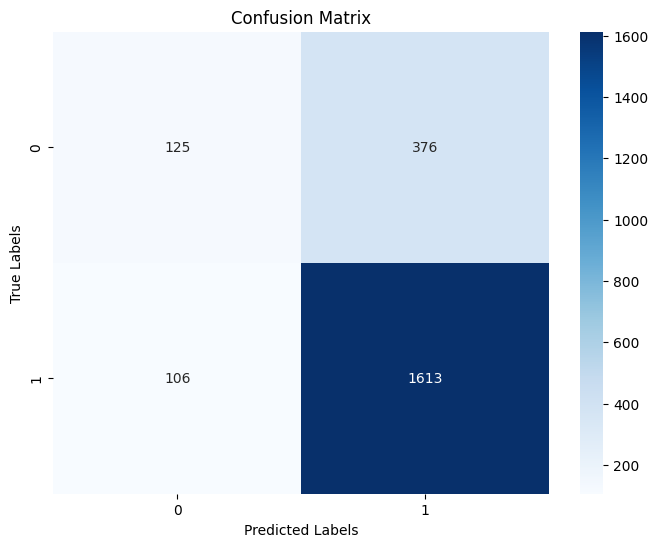

In [63]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Construct a confusion matrix of predictions and actual labels.
conf_matrix_tf = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes = 2)

# Convert the TensorFlow tensor to a NumPy array
conf_matrix_np = conf_matrix_tf.numpy()
print(conf_matrix_tf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues', xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#predictions
#print(predictions.shape)